In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn.decomposition
import pandas_datareader.data as web

In [2]:

stock= ['ALGN','COHR','ANET','ABMD','TREX','WLK','PAYC','PPC','FIVE','NVDA']
original= web.DataReader(stock,data_source="yahoo",start='01/01/2018',end='31/12/2018')['Adj Close']

In [3]:
original.shape

(251, 10)

In [4]:
## compute daily return and normalize
asset_returns=original.pct_change().dropna()
normed_returns=(asset_returns-asset_returns.mean(axis=0))/asset_returns.std(axis=0)

In [5]:
normed_returns.head(5)

Symbols,ABMD,ALGN,ANET,COHR,FIVE,NVDA,PAYC,PPC,TREX,WLK
Date,,,,,,,,,,
2018-01-03,0.491598,0.989820,0.645434,0.701746,0.788733,2.159706,0.195789,-0.649231,1.656604,-0.360514
2018-01-04,0.498812,0.302993,-0.408668,-0.739912,0.871140,0.205589,0.873852,-0.278309,-1.579351,0.550537
2018-01-05,0.428542,1.126121,0.571723,0.890747,-0.204635,0.308967,0.267171,0.054290,0.662666,0.884792
2018-01-08,0.817785,1.098097,1.976421,0.570740,-2.782250,1.024427,0.259619,1.416254,-0.390049,0.483969
2018-01-09,0.229363,0.341118,-0.144599,0.199849,0.443848,0.026723,-0.040505,-0.239051,1.220966,0.021760


In [6]:
## construct covariance matrix and fit PCA
cov_matrix=normed_returns.cov()
cov_matrix_raw=asset_returns.cov()
pca=sklearn.decomposition.PCA().fit(cov_matrix)

In [7]:
## variance explained
explain=pca.explained_variance_ratio_
pcs=pca.components_

In [8]:
explain

array([3.91167927e-01, 1.42025605e-01, 1.32144658e-01, 9.89163143e-02,
       8.63894947e-02, 5.30311429e-02, 3.88527774e-02, 3.56202272e-02,
       2.18518541e-02, 7.50415242e-36])

Text(0.5, 1.0, 'Variance explained by Pcs')

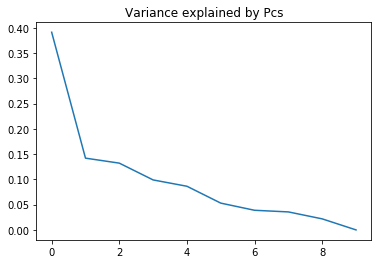

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(explain)
plt.title('Variance explained by Pcs')

In [10]:
## normalize
normalized_portfolio={}
for i in range(len(pcs)):
    portfolio=pcs[:,i]
    normalized_portfolio['pc'+str(i)]=portfolio/np.sum(portfolio)

## pc1 is market factor and largest source of systematic risk
market_factor=normalized_portfolio['pc0']

In [11]:
## since first 5 PCs explain about 88% of total variance, reconstruct data with first 2 PCs to reduce noise
## before optimizing portfolio. However, these hidden factors should also be paid attention to.
copy=asset_returns.copy()
pc_use=sklearn.decomposition.PCA(n_components=5).fit(asset_returns)
projected = pc_use.inverse_transform(pc_use.transform(copy))

In [12]:
projected=pd.DataFrame(data=projected,index=normed_returns.index,columns=normed_returns.columns)

In [13]:
## examine the loss between projected and original. All stocks seem to have similar loss.
loss=((asset_returns-projected)**2).mean()
print(loss)

Symbols
ABMD    0.000143
ALGN    0.000160
ANET    0.000200
COHR    0.000042
FIVE    0.000019
NVDA    0.000215
PAYC    0.000286
PPC     0.000289
TREX    0.000034
WLK     0.000256
dtype: float64


Compare the projected data with original data for the stock with largest loss (NVDA) and smallest loss (FIVE).

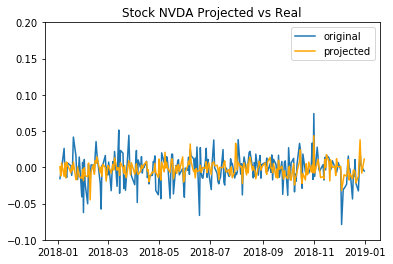

In [14]:
plt.plot(asset_returns.PPC,label='original')
plt.plot(projected.PPC,color='orange',label='projected')
plt.ylim(top=0.2)
plt.ylim(bottom=-0.1)
plt.title('Stock NVDA Projected vs Real')
plt.legend()

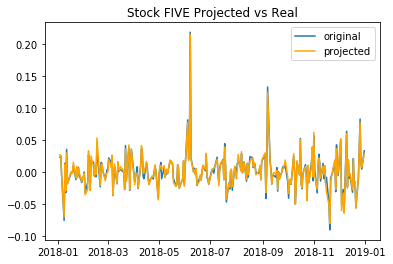

In [17]:
plt.plot(asset_returns.FIVE,label='original')
plt.plot(projected.FIVE,color='orange',label='projected')
plt.title('Stock FIVE Projected vs Real')
plt.legend()

The first 5 PCs catch clearly more features of FIVE than NVDA. It is highly likely that during this period, NVDA's price was affected a lot by unseen factors while FIVE's price was not.

In [20]:
## since the interest rates are so low, it is commonly assumed that the risk free rate is zero
def sharpe_ratio(returns,weights,days=252):
    annualized_return=np.sum(returns.mean()*weights)*252
    annualized_vol=np.sqrt(np.dot(weights.T, np.dot(cov_matrix_raw,weights)))*np.sqrt(days)
    sharpe_ratio=annualized_return/annualized_vol
    return annualized_return,annualized_vol,sharpe_ratio

In [21]:
sharpe_ratio(projected,normalized_portfolio['pc0'],days=252)

(0.9446383821550878, 0.4346175804882838, 2.1734932606587294)

In [22]:
## generate n portfolio with random weights
def generate_random_portfolio(n,returns):
    results=np.zeros((3,n))
    results[1,:]=100
    all_weights=[]
    for i in range(n):
        weights=np.random.random(returns.shape[1])
        weights/=np.sum(weights)
        annualized_return,annualized_vol,sr=sharpe_ratio(returns,weights)
        if annualized_return>0:
            results[0,i]=annualized_return
            results[1,i]=annualized_vol
            results[2,i]=sr
        all_weights.append(weights)
    return results,all_weights        

In [23]:
## find the portfolio with larget sharpe ratio (tangency portfolio) and minimum volatility (min variance portfolio)
## in generated n random portfolios
def find_optimal(returns,n):
    results,all_weights=generate_random_portfolio(n,returns)
    ## tangency portfolio
    max_sr_idx=np.argmax(results[2])
    msr_port_return,msr_port_vol=results[0,max_sr_idx], results[1,max_sr_idx]
    max_sr_loadings=pd.DataFrame(all_weights[max_sr_idx],index=projected.columns,columns=['loadings'])
    max_sr_loadings.loadings=[round(i*100,2) for i in max_sr_loadings.loadings]

    ## min variance portfolio
    
    min_vol_idx=np.argmin(results[1])
    mv_port_return,mv_port_vol=results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_loadings=pd.DataFrame(all_weights[min_vol_idx],index=projected.columns,columns=['loadings'])
    min_vol_loadings.loadings=[round(i*100,2) for i in min_vol_loadings.loadings]
    
    print ("Maximum Sharpe Ratio Portfolio Loadings\n")
    print ("Annualised Return:", round(msr_port_return,4))
    print ("Annualised Volatility:", round(msr_port_vol,2))
    print ("\n")
    print (max_sr_loadings.T)
    print ("\n")
    print ("Minimum Volatility Portfolio Loadings\n")
    print ("Annualised Return:", round(mv_port_return,4))
    print ("Annualised Volatility:", round(mv_port_vol,2))
    print ("\n")
    print (min_vol_loadings.T)  

In [24]:
find_optimal(projected,50000)

Maximum Sharpe Ratio Portfolio Loadings

Annualised Return: 0.3521
Annualised Volatility: 0.31


Symbols    ABMD  ALGN   ANET  COHR   FIVE  NVDA  PAYC   PPC  TREX  WLK
loadings  22.59  7.44  10.07  1.16  26.53  1.09  22.5  5.13   2.7  0.8


Minimum Volatility Portfolio Loadings

Annualised Return: 0.0308
Annualised Volatility: 0.25


Symbols    ABMD  ALGN  ANET  COHR   FIVE  NVDA   PAYC    PPC  TREX    WLK
loadings  10.19  4.09  0.66  2.05  15.25  0.97  14.19  18.32  16.7  17.58


In [25]:
projected.std()

Symbols
ABMD    0.027498
ALGN    0.026554
ANET    0.026997
COHR    0.030603
FIVE    0.027263
NVDA    0.027279
PAYC    0.021070
PPC     0.010852
TREX    0.026200
WLK     0.011128
dtype: float64

For the min variance portfolio, larger percent of portfolio is given to stocks with smaller std in generall.